<img src="../img/hu-logo.png" align="right" width="120">

# Our first neural network with `PyTorch`

This includes the following steps:
1. Create a data set that requires a nonlinear decision boundary (spiral data)
1. Implement inference using `torch.nn`
1. Evaluate model
1. Vary architecture

Check out this http://playground.tensorflow.org/ to experiment quickly with some simple features, hyperparameters and architectures.

In [1]:
import l08_lib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import sklearn.model_selection
import torch
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data

In [2]:
plt.rcParams.update(
    {
        "figure.figsize": (9, 9),
        "axes.titlesize": 20,
        "axes.labelsize": 15,
        "legend.fontsize": 15,
        "axes.grid": True,
        "axes.axisbelow": True,
        "pcolor.shading": "auto",
    }
)

In [3]:
def score(x, y, trainer):

    p = trainer.predict(x).data.numpy()
    yhat = (p > 0.5).astype(int)

    accuracy = np.mean(y == yhat)
    average_precision = sklearn.metrics.average_precision_score(y, p)
    rocauc = sklearn.metrics.roc_auc_score(y, p)
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y, p)
    prauc = sklearn.metrics.auc(recall, precision)

    xx = np.linspace(-20, 20, 400)
    yy = np.linspace(-20, 20, 400)
    gx, gy = np.meshgrid(xx, yy)
    Z = (
        trainer.predict(torch.tensor(np.c_[gx.ravel(), gy.ravel()].astype(np.float32)))
        .detach()
        .numpy()
        .reshape(gx.shape)
    )

    plt.contourf(gx, gy, Z, cmap=plt.cm.coolwarm, alpha=0.7)

    mask_11 = (y == 1) & (yhat == 1)
    mask_10 = (y == 1) & (yhat == 0)
    mask_00 = (y == 0) & (yhat == 0)
    mask_01 = (y == 0) & (yhat == 1)

    plt.scatter(
        x[mask_11, 0],
        x[mask_11, 1],
        s=100,
        c="darkred",
        marker="o",
        label="True Positive",
    )
    plt.scatter(
        x[mask_10, 0],
        x[mask_10, 1],
        s=100,
        c="darkred",
        marker="^",
        label="False Negative",
    )
    plt.scatter(
        x[mask_00, 0],
        x[mask_00, 1],
        s=100,
        c="darkblue",
        marker="o",
        label="True Negative",
    )
    plt.scatter(
        x[mask_01, 0],
        x[mask_01, 1],
        s=100,
        c="darkblue",
        marker="^",
        label="False Positive",
    )

    plt.title(
        f"acc={accuracy:.2f} | avg(prec)={average_precision:.2f} | rocauc={rocauc:.2f} | prauc={prauc:.2f}"
    )
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.legend(loc="upper left")
    plt.tight_layout()

## Data

In [4]:
X, y = l08_lib.generate_data(N=2_000)

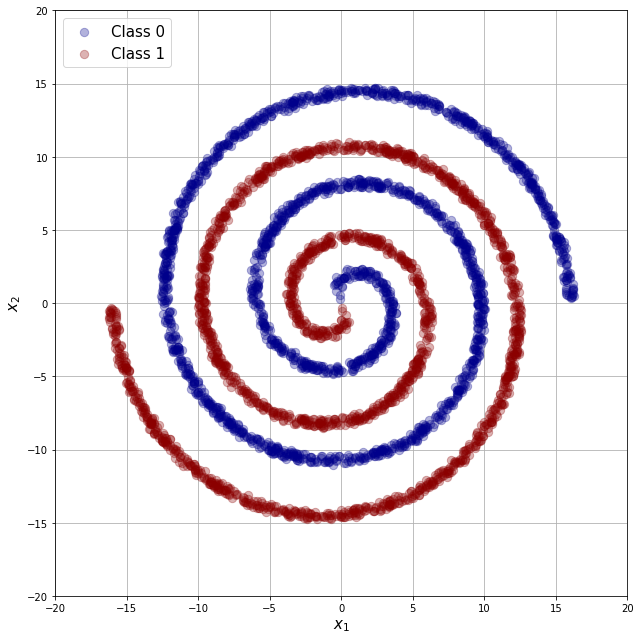

In [5]:
l08_lib.plot_spiral(X, y, xlim=(-20, 20), ylim=(-20, 20))

In [6]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.1, random_state=501
)

In [7]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    x_train, y_train, test_size=0.20, random_state=501
)

## Our first `torch` model

In [8]:
config = {
    "trainer": {
        "epochs": 2_000,
    },
    "model": {
        "n_features": x_train.shape[1],
        "layers": [20, 15, 10, 5],
    },
    "data": {
        "train": {
            "batch_size": 512,
            "shuffle": True,
            "drop_last": True,
        },
        "valid": {
            "batch_size": x_valid.shape[0],
            "shuffle": False,
            "drop_last": False,
        },
        "test": {
            "batch_size": x_test.shape[0],
            "shuffle": False,
            "drop_last": False,
        },
    },
    "optimizer": {
        "lr": 0.01,
    },
}

In [9]:
xt_train, yt_train, xt_valid, yt_valid, xt_test, yt_test = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test)
)

In [10]:
ds_train = torch.utils.data.TensorDataset(xt_train, yt_train)
dl_train = torch.utils.data.DataLoader(ds_train, **config["data"]["train"])

In [11]:
class Trainer:
    def __init__(self, train, validation, model):
        self.train = train
        self.validation = validation
        self.model = model
        self.opt = torch.optim.Adam(self.model.parameters())

    def fit(self, n_epochs):
        for epoch in range(n_epochs):

            self.model.train()
            for xb, yb in self.train:
                self.opt.zero_grad()
                loss_train = torch.nn.functional.binary_cross_entropy_with_logits(
                    self.model(xb).flatten(), yb
                )
                loss_train.backward()
                self.opt.step()

            self.model.eval()
            with torch.no_grad():
                loss_valid = torch.nn.functional.binary_cross_entropy_with_logits(
                    self.model(self.validation[0]).flatten(), self.validation[1]
                )

    def predict(self, x):
        return torch.sigmoid(self.model(x))

## Feed-forward with 1 layer

In [12]:
torch.manual_seed(501)
np.random.seed(501)

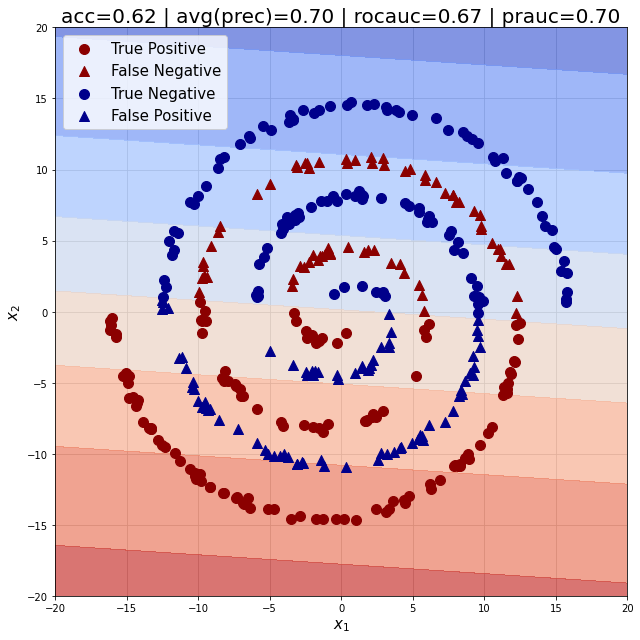

In [13]:
class Net00(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.h0 = torch.nn.Linear(2, 1)

    def forward(self, xb):
        return self.h0(xb).flatten()


trainer_00 = Trainer(dl_train, [xt_valid, yt_valid], Net00())
trainer_00.fit(n_epochs=config["trainer"]["epochs"])

score(xt_test, y_test, trainer_00)

## Feed-forward with 2 layers

In [14]:
torch.manual_seed(501)
np.random.seed(501)

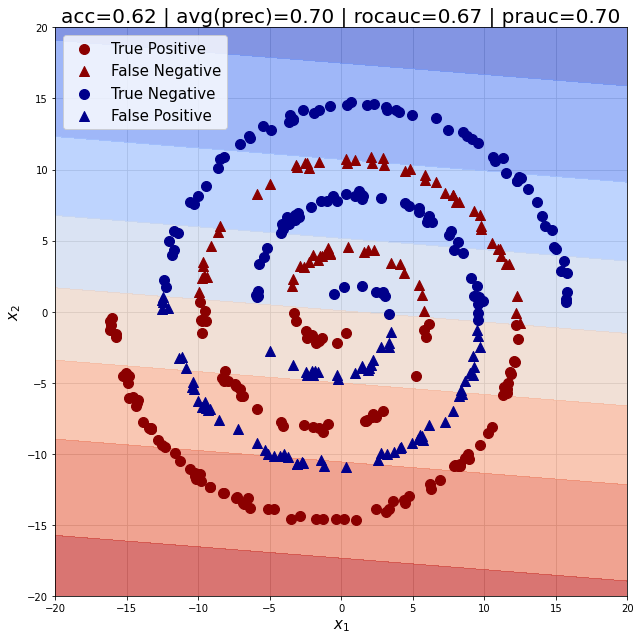

In [15]:
class Net01(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.h0 = torch.nn.Linear(2, 6)
        self.h1 = torch.nn.Linear(6, 1)

    def forward(self, xb):
        xb = self.h0(xb)
        xb = self.h1(xb)
        return xb.flatten()


trainer_01 = Trainer(dl_train, [xt_valid, yt_valid], Net01())
trainer_01.fit(n_epochs=config["trainer"]["epochs"])

score(xt_test, y_test, trainer_01)

## Feed-forward with 3 layers

In [16]:
torch.manual_seed(501)
np.random.seed(501)

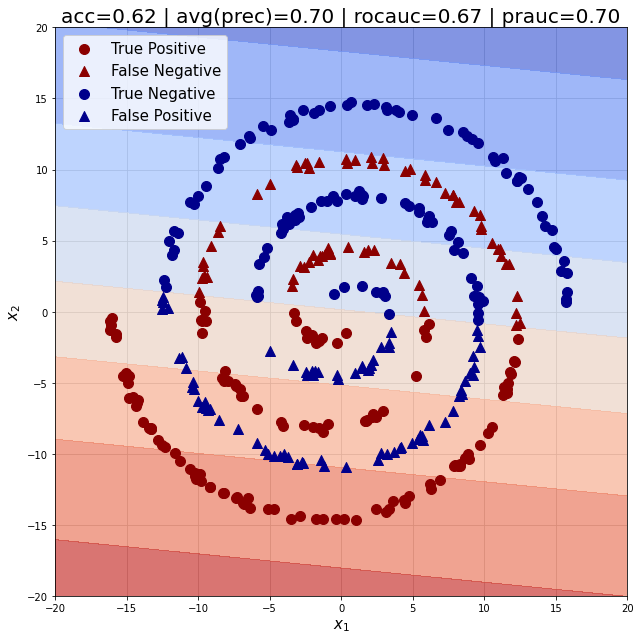

In [17]:
class Net02(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.h0 = torch.nn.Linear(2, 12)
        self.h1 = torch.nn.Linear(12, 6)
        self.h2 = torch.nn.Linear(6, 1)

    def forward(self, xb):
        xb = self.h0(xb)
        xb = self.h1(xb)
        xb = self.h2(xb)
        return xb.flatten()


trainer_02 = Trainer(dl_train, [xt_valid, yt_valid], Net02())
trainer_02.fit(n_epochs=config["trainer"]["epochs"])

score(xt_test, y_test, trainer_02)

## Multilayer perceptron

In [18]:
torch.manual_seed(501)
np.random.seed(501)

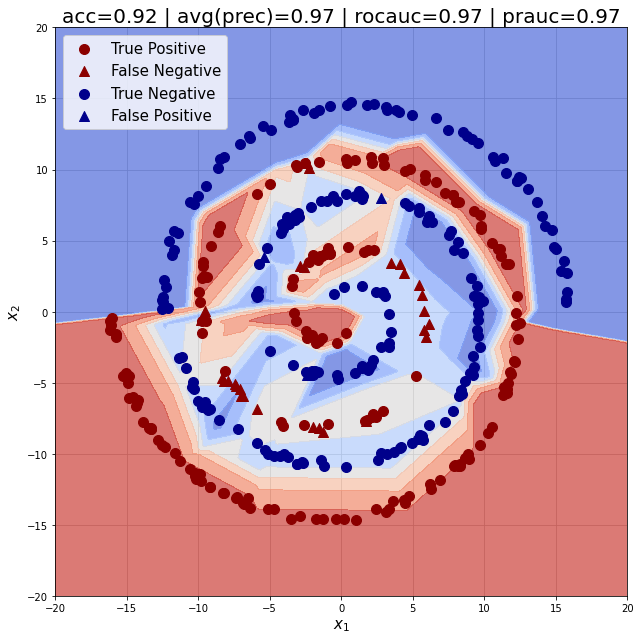

In [19]:
class Net03(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.h0 = torch.nn.Linear(2, 12)
        self.h1 = torch.nn.Linear(12, 6)
        self.h2 = torch.nn.Linear(6, 1)

    def forward(self, xb):
        xb = self.h0(xb)
        xb = torch.nn.functional.relu(xb)
        xb = self.h1(xb)
        xb = torch.nn.functional.relu(xb)
        xb = self.h2(xb)
        return xb.flatten()


trainer_03 = Trainer(dl_train, [xt_valid, yt_valid], Net03())
trainer_03.fit(n_epochs=config["trainer"]["epochs"])

score(xt_test, y_test, trainer_03)

## Generalize multilayer perceptron

In [20]:
torch.manual_seed(501)
np.random.seed(501)

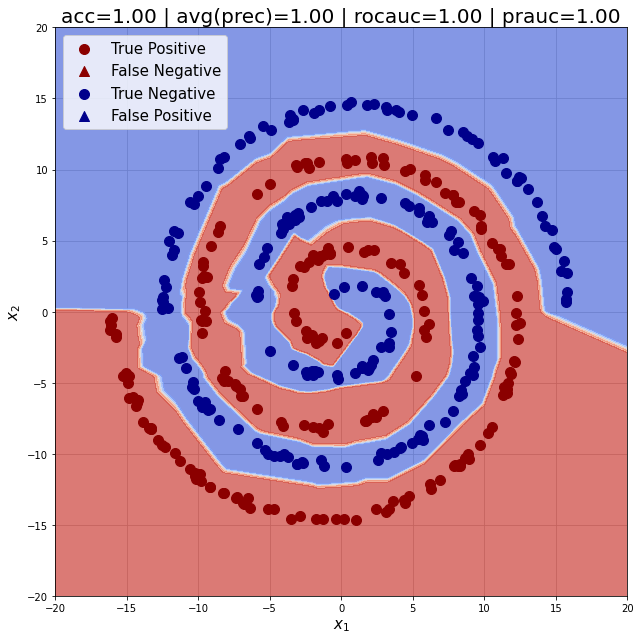

In [21]:
class Net(torch.nn.Module):
    def __init__(self, n_features, layers):
        super().__init__()
        self.hidden = torch.nn.ModuleList()
        layers_in = [n_features] + config["model"]["layers"]
        layers_out = config["model"]["layers"] + [1]
        for i in range(len(layers) + 1):
            self.hidden.append(torch.nn.Linear(layers_in[i], layers_out[i]))

    def forward(self, xb):
        for i, h in enumerate(self.hidden):
            xb = h(xb)
            if i < (len(self.hidden) - 1):
                xb = torch.nn.functional.relu(xb)
        return xb.flatten()


trainer = Trainer(dl_train, [xt_valid, yt_valid], Net(**config["model"]))
trainer.fit(n_epochs=config["trainer"]["epochs"])

score(xt_test, y_test, trainer)

<br>
<br>
&mdash; <br>
Dr. Sebastian Gabel <br>
Machine Learning in Marketing &ndash; Lecture 8 <br>
2021